In [1]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

In [2]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.5490036010742188}]

In [3]:
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus")


Found cached dataset clinc_oos (C:/Users/caiji/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [5]:
intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"])


'transfer'

In [14]:
from datasets import load_metric

accuracy_score = load_metric("accuracy")

C:\Users\caiji\AppData\Local\Temp\ipykernel_3888\3510557904.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_score = load_metric("accuracy")


In [15]:
def compute_accuracy(self):
  preds, labels = [], []
  for example in self.dataset:
    pred = self.pipeline(example["text"])[0]["label"]
    label = example["intent"]
    preds.append(intents.str2int(pred))
    labels.append(label)
  accuracy = accuracy_score.compute(predictions=preds, references=labels)
  print(f"accuracy on test set - {accuracy['accuracy']:.3f}")
  return accuracy

In [9]:
list(pipe.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.weight',
 tensor([[-1.0526e-02, -3.2215e-02,  2.2097e-02,  ..., -6.0953e-03,
           4.6521e-03,  2.9844e-02],
         [-1.4964e-02, -1.0915e-02,  5.2396e-04,  ...,  3.2047e-05,
          -2.6890e-02, -2.1943e-02],
         [-2.9640e-02, -3.7842e-03, -1.2582e-02,  ..., -1.0917e-02,
           3.1152e-02, -9.7786e-03],
         ...,
         [-1.5116e-02, -3.3226e-02,  4.2063e-02,  ..., -5.2652e-03,
           1.1093e-02,  2.9703e-03],
         [-3.6809e-02,  5.6848e-02, -2.6544e-02,  ..., -4.0114e-02,
           6.7487e-03,  1.0511e-03],
         [-2.4961e-02,  1.4747e-03, -5.4271e-02,  ...,  2.0004e-02,
           2.3981e-02, -4.2880e-02]]))

In [7]:
import torch
torch.save(pipe.model.state_dict(), "model.pt")

In [8]:
import torch
from pathlib import Path

def compute_size(self):
  """this overrides the PerformanceBenchmark.compute_size() method"""
  state_dict = self.pipeline.model.state_dict()
  tmp_path = Path("model.pt")
  torch.save(state_dict, tmp_path)
  # calculate size in megabytes
  size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
  # delete temporary file
  tmp_path.unlink()
  print(f"Model size (MB) - {size_mb:.2f}")
  return {"size_mb": size_mb}


In [12]:
from time import perf_counter

for _ in range(3):
  start_time = perf_counter()
  _ = pipe(query)
  latency = perf_counter() - start_time
  print(f"Latency (ms) - {1000 * latency:.3f}")

Latency (ms) - 50.579
Latency (ms) - 45.495
Latency (ms) - 44.314


In [9]:
import numpy as np

def time_pipeline(self, query="Waht is the pin number for my account?"):
  """this overrides the PerformanceBenchmark.time_pipeline() method"""
  latencies = []
  # warmup
  for _ in range(10):
    _ = self.pipeline(query)
  # time run
  for _ in range(100):
    start_time = perf_counter()
    _ = self.pipeline(query)
    latency = perf_counter() - start_time
    latencies.append(latency)
  # compute run statistics
  time_avg_ms = 1000 * np.mean(latencies)
  time_std_ms = 1000 * np.std(latencies)
  print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
  return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}



In [16]:
class PerformanceBenchmark:
  def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
    self.pipeline = pipeline 
    self.dataset = dataset
    self.optim_type = optim_type
  
  def compute_accuracy(self):
    pass 

  def compute_size(self):
    pass
  
  def time_pipeline(self):
    pass
  
  def run_benchmark(self):
    metrics = {}
    metrics[self.optim_type] = self.compute_size()
    metrics[self.optim_type].update(self.time_pipeline())
    metrics[self.optim_type].update(self.compute_accuracy())
    return metrics

PerformanceBenchmark.compute_accuracy = compute_accuracy
PerformanceBenchmark.compute_size = compute_size
PerformanceBenchmark.time_pipeline = time_pipeline

In [17]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

Model size (MB) - 418.15
Average latency (ms) - 31.93 +\- 3.54
accuracy on test set - 0.867


**Making Models Smaller via Knowledge Distillation**

In [24]:
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
  def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
    super().__init__(*args, **kwargs)
    self.alpha = alpha
    self.temperature = temperature


In [28]:
import torch.nn as nn
import torch.nn.functional as F 
from transformers import Trainer 

class DistillationTrainer(Trainer):
  def __init__(self, *args, teacher_model=None, **kwargs):
    super().__init__(*args, **kwargs)
    self.teacher_model = teacher_model

  def compute_loss(self, model, inputs, return_outputs=False):
    output_stu = model(**input)
    # extract cross-entropy loss and logits from student
    loss_ce = output_stu.loss
    logits_stu = output_stu.logits
    # extract logits from teacher
    with torch.no_grad():
      outputs_tea = self.teacher_model(**inputs)
      logits_tea = outputs_tea.logits
    # soften probabilities and compute distillation loss
    loss_fct = nn.KLDivLoss(reduction="batchmean")
    loss_kd = self.args.temperature ** 2 * loss_fct(
        F.log_softmax(logits_stu / self.args.temperature, dim=-1), 
        F.softmax(logits_tea / self.args.temperature, dim=-1))
    # return weighted student loss
    loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
    return (loss, output_stu) if return_outputs else loss

In [25]:
from transformers import AutoTokenizer

student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
  return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

Loading cached processed dataset at C:\Users\caiji\.cache\huggingface\datasets\clinc_oos\plus\1.0.0\abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1\cache-5c16ab8bf708ecb6.arrow
Loading cached processed dataset at C:\Users\caiji\.cache\huggingface\datasets\clinc_oos\plus\1.0.0\abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1\cache-776b71e48ffdab8a.arrow


Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

In [18]:
def compute_metrics(pred):
  predictions, labels = pred
  predictions = np.argmax(predictions, axis=1)
  return accuracy_score.compute(predictions=predictions, references=labels)

In [ ]:
batch_size = 48

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTrainingArguments(
    output_dir=finetuned_ckpt, evaluation_strategy="epoch", 
    num_train_epochs=5, learing_rate=2e-5, 
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size, alpha=1, weight_decay=0.01, 
    push_to_hub=False)

In [ ]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

In [ ]:
from transformers import AutoConfig

num_labels = intents.num_classes
student_config = (AutoConfig
                  .from_pretrained(student_ckpt, num_labels=num_labels, 
                                   id2label=id2label, label2id=label2id))

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
  return (AutoModelForSequenceClassification
          .from_pretrained(student_ckpt, config=student_config).to(device))


In [ ]:
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(teacher_ckpt, num_labels=num_labels)
                 .to(device))

distilbert_trainer = DistillationTrainer(
    model_init=student_init, 
    teacher_model=teacher_model, args=student_training_args, 
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'], 
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distilbert_trainer.train()

In [19]:
finetuned_ckpt = "transformersbook/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)

In [20]:
optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.88
Average latency (ms) - 16.05 +\- 1.25
accuracy on test set - 0.858


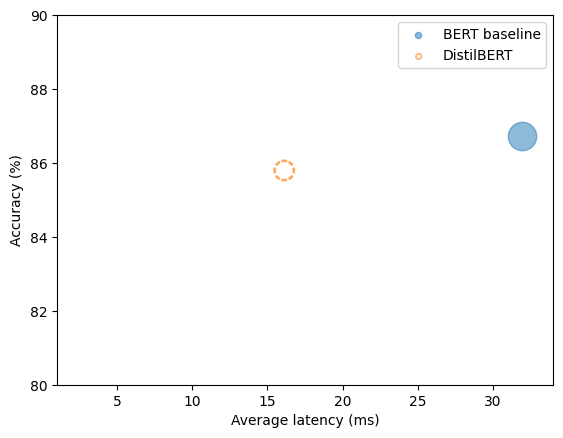

In [21]:
import pandas as pd 
import matplotlib.pyplot as plt

def plot_metrics(perf_metrics, current_optim_type):
  df = pd.DataFrame.from_dict(perf_metrics, orient='index')

  for idx in df.index:
    df_opt = df.loc[idx]
    # add a dashed circle around the current optimization type
    if idx == current_optim_type:
      plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                  alpha=0.5, s=df_opt["size_mb"], label=idx, 
                  marker='$\u25CC$')
    else:
      plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                  s=df_opt["size_mb"], label=idx, alpha=0.5)
    
  legend = plt.legend(bbox_to_anchor=(1,1))
  for handle in legend.legendHandles:
    handle.set_sizes([20])
  
  plt.ylim(80, 90)
  # use the slowest model to define the x-aixs range
  xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
  plt.xlim(1, xlim)
  plt.ylabel("Accuracy (%)")
  plt.xlabel("Average latency (ms)")
  plt.show()

plot_metrics(perf_metrics, optim_type)

**Optuna**

In [34]:
def objective(trial):
  x = trial.suggest_float("x", -2, 2)
  y = trial.suggest_float("y", -2, 2)
  return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

In [38]:
import optuna

study = optuna.create_study()
study.optimize(objective, n_trials=1000)

[I 2023-05-10 10:26:38,258] A new study created in memory with name: no-name-b3522001-e50a-4610-bd65-3360fe2d68fb
[I 2023-05-10 10:26:38,267] Trial 0 finished with value: 81.77279678891887 and parameters: {'x': 1.4644701866004985, 'y': 1.2415834289163414}. Best is trial 0 with value: 81.77279678891887.
[I 2023-05-10 10:26:38,272] Trial 1 finished with value: 25.374803858118955 and parameters: {'x': 1.2126191728154914, 'y': 0.9671600812133816}. Best is trial 1 with value: 25.374803858118955.
[I 2023-05-10 10:26:38,277] Trial 2 finished with value: 177.15276550986414 and parameters: {'x': 0.6866054408806166, 'y': 1.8020454942684911}. Best is trial 1 with value: 25.374803858118955.
[I 2023-05-10 10:26:38,281] Trial 3 finished with value: 419.0801399515759 and parameters: {'x': 1.2833413936388363, 'y': -0.3999834685994199}. Best is trial 1 with value: 25.374803858118955.
[I 2023-05-10 10:26:38,285] Trial 4 finished with value: 183.72203521057537 and parameters: {'x': 0.08934015194103351, '

In [39]:
study.best_params

{'x': 0.8969957792123515, 'y': 0.8018863280356061}

In [40]:
def hp_space(trial):
  return {"num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10), 
          "alpha": trial.suggest_float("alpha", 0, 1), 
          "temperature": trial.suggest_int("temperature", 2, 20)}

In [ ]:
best_run = distilbert_trainer.hyperparameter_search(
    n_trials=20, direction="maximize", hp_space=hp_space)
print(best_run)

In [ ]:
for k, v in best_run.hyperparameters.items():
  setattr(student_training_args, k, v)

# define a new repository to store our distilled model
distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

# create a new trainer with optimal parameters
distil_trainer = DistillationTrainer(
    model_init=student_init, 
    teacher_model=teacher_model, args=student_training_args, 
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'], 
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distil_trainer.train();

In [22]:
distilled_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "Distillation"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())


Model size (MB) - 255.88
Average latency (ms) - 18.61 +\- 1.87
accuracy on test set - 0.868


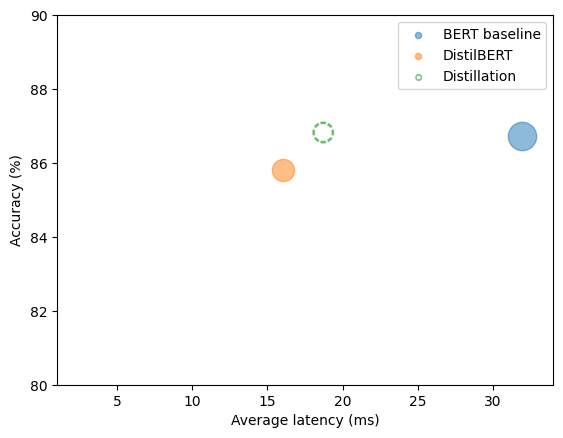

In [23]:
plot_metrics(perf_metrics, optim_type)

**Making Models Faster with Quantization**

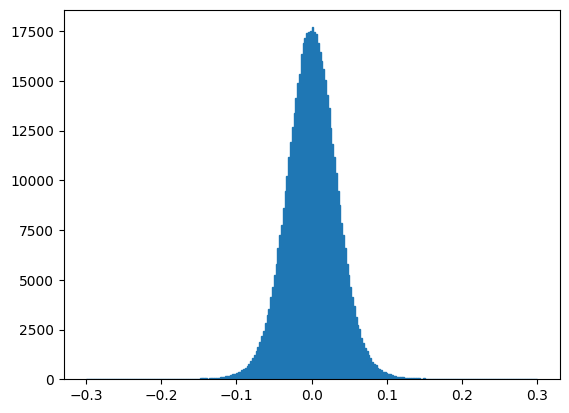

In [50]:
import matplotlib.pyplot as plt

state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]
plt.hist(weights.flatten().numpy(), bins=250, range=(-0.3,0.3), edgecolor="C0")
plt.show()

In [51]:
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128))

In [52]:
(weights / scale + zero_point).clamp(-128, 127).round().char()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  8,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -6,   5,  ...,   1,   5,  -3],
        ...,
        [  6,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

In [53]:
from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  8,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -6,   5,  ...,   1,   5,  -3],
        ...,
        [  6,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

In [55]:
%%timeit
weights @ weights 

3.71 ms ± 372 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [57]:
from torch.nn.quantized import QFunctional

q_fn = QFunctional()

In [58]:
%%timeit
q_fn.mul(quantized_weights, quantized_weights)

180 µs ± 807 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [59]:
import sys

sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())

C:\Users\caiji\AppData\Local\Temp\ipykernel_10836\2099325647.py:3: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())
C:\Users\caiji\AppData\Roaming\Python\Python39\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


3.999755879241598

In [27]:
import torch
from torch import nn
from transformers import AutoModelForSequenceClassification
from torch.quantization import quantize_dynamic 

model_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt).to("cpu"))

model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)


In [28]:
pipe = pipeline("text-classification", model=model_quantized, 
                tokenizer=tokenizer)
optim_type = "Distillation + quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 132.39
Average latency (ms) - 11.98 +\- 1.38
accuracy on test set - 0.876


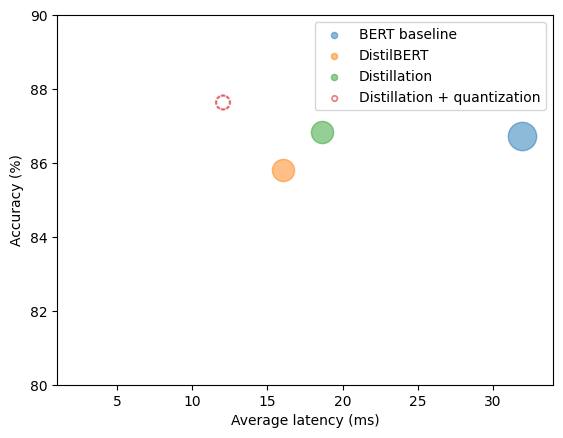

In [29]:
plot_metrics(perf_metrics, optim_type)

**Optimizing Inference with ONNX and the ONNX Runtime**

In [30]:
import os
from psutil import cpu_count 

os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"

In [ ]:
from pathlib import Path
from transformers import AutoTokenizer
from transformers.convert_graph_to_onnx import convert

model_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
onnx_model_path = Path("onnx/model.onnx")
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

convert(framework="pt", model=model_ckpt, tokenizer=tokenizer, 
        output=onnx_model_path, opset=12, pipeline_name="text-classification")

In [32]:
from onnxruntime import (GraphOptimizationLevel, InferenceSession, 
                         SessionOptions)

def create_model_for_provider(model_path, provider="CPUExecutionProvider"):
  options = SessionOptions()
  options.intra_op_num_threads = 1
  options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
  session = InferenceSession(str(model_path), options, providers=[provider])
  session.disable_fallback()
  return session

onnx_model = create_model_for_provider(onnx_model_path)

In [10]:
inputs = clinc_enc["test"][:1]
del inputs["labels"]
logits_onnx = onnx_model.run(None, inputs)[0]
logits_onnx.shape

(1, 151)

In [13]:
import numpy as np
np.argmax(logits_onnx)

61

In [14]:
clinc_enc["test"][0]["labels"]

61

In [33]:
from scipy.special import softmax

class OnnxPipeline:
  def __init__(self, model, tokenizer):
    self.model = model
    self.tokenizer = tokenizer
  
  def __call__(self, query):
    model_inputs = self.tokenizer(query, return_tensors="pt")
    inputs_onnx = {k: v.cpu().detach().numpy()
                   for k, v in model_inputs.items()}
    logits = self.model.run(None, inputs_onnx)[0][0, :]
    probs = softmax(logits)
    pred_idx = np.argmax(probs).item()
    return [{"label": intents.int2str(pred_idx), "score": probs[pred_idx]}]

In [22]:
pipe = OnnxPipeline(onnx_model, tokenizer)
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.7848335}]

In [34]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
  def __init__(self, *args, model_path, **kwargs):
    super().__init__(*args, **kwargs)
    self.model_path = model_path

  def compute_size(self):
    size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
    print(f"Model size (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}

In [35]:
optim_type = "Distillation + ORT"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path="onnx/model.onnx")
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.98
Average latency (ms) - 17.53 +\- 5.32
accuracy on test set - 0.876


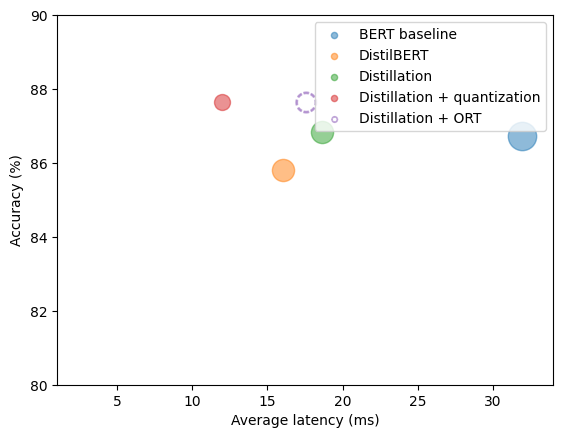

In [37]:
plot_metrics(perf_metrics, optim_type)

In [38]:
from onnxruntime.quantization import quantize_dynamic, QuantType

model_input = "onnx/model.onnx"
model_output = "onnx/model.quant.onnx"
quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)

Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.5/attention/MatMul]
Ignore MatM

In [39]:
onnx_quantized_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quantized_model, tokenizer)
optim_type = "Distillation + ORT (quantized)"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path=model_output)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 64.31
Average latency (ms) - 19.05 +\- 3.50
accuracy on test set - 0.876


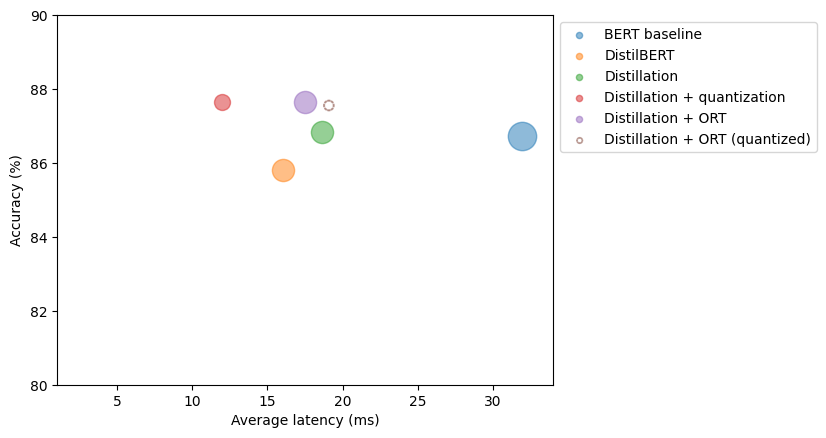

In [40]:
plot_metrics(perf_metrics, optim_type)